# Install Necessary Libraries

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Configuration and Optimization (For Realistic Mode)

In [2]:
# ==============================================================================
# IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve, recall_score, f1_score, balanced_accuracy_score,
    roc_auc_score, confusion_matrix, precision_score, classification_report,
    matthews_corrcoef, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler


# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "realistic"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# LOAD DATA
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# ==============================================================================
# DROP LEAKAGE & IRRELEVANT COLUMNS
# ==============================================================================
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat', 'Age'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')


# Drop CA/PA in realistic mode
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic → Dropped CA & PA")
else:
    print("MODE=full → Keeping CA & PA")

# Feature engineering only if CA and PA exist
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]


# ==============================================================================
# SPLIT DATA
# ==============================================================================
X = df.drop(columns=["success_label"])
y = df["success_label"]

print(f"\nFeatures: {X.shape[1]} | Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED
)

# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)


# ==============================================================================
# OPTUNA OBJECTIVE
# ==============================================================================
def objective(trial):
    # SMOTE settings
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]

    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

    # SVC hyperparameters
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    max_iter = trial.suggest_int("max_iter", 1000, 5000)

    clf = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        max_iter=max_iter,
        probability=False,   # faster for Optuna
        random_state=SEED
    )

    pipe = ImbPipeline([
        ("smote", smote),
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])

    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    return balanced_accuracy_score(y_val, y_val_pred)


# ==============================================================================
# RUN OPTUNA
# ==============================================================================
study = optuna.create_study(direction="maximize", study_name="SVC_Study")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best_params = study.best_params
print("\nBest Hyperparameters:")
print(best_params)


# ==============================================================================
# FINAL MODEL TRAINING (TRAIN + VALIDATION)
# ==============================================================================
best_params_svm = study.best_params
smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[best_params_svm['smote_level']]
best_smote_svm = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

final_svm = SVC(
    C=best_params_svm["C"],
    kernel=best_params_svm["kernel"],
    gamma=best_params_svm["gamma"],
    max_iter=best_params_svm["max_iter"],
    probability=True,   # required for thresholds & PR curve
    random_state=SEED
)

final_pipe_svm = ImbPipeline([
    ("smote", best_smote_svm),
    ("scaler", StandardScaler()),
    ("clf", final_svm)
])

# Combine TRAIN + VALIDATION
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])

final_pipe_svm.fit(X_train_final, y_train_final)

Reading file...


[I 2025-12-08 17:26:39,914] A new study created in memory with name: SVC_Study


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=realistic → Dropped CA & PA

Features: 62 | Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4274).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:27:12,888] Trial 0 finished with value: 0.5834456394689556 and parameters: {'smote_level': 'high', 'C': 357.5474134794552, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4274}. Best is trial 0 with value: 0.5834456394689556.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4355).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:27:54,791] Trial 1 finished with value: 0.5327399644109488 and parameters: {'smote_level': 'high', 'C': 0.00555720413481184, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4355}. Best is trial 0 with value: 0.5834456394689556.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2013).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:28:09,321] Trial 2 finished with value: 0.5942139442787111 and parameters: {'smote_level': 'medium', 'C': 0.008187931421968348, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 2013}. Best is trial 2 with value: 0.5942139442787111.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4750).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:28:37,938] Trial 3 finished with value: 0.6122036426440571 and parameters: {'smote_level': 'medium', 'C': 10.19174435604664, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4750}. Best is trial 3 with value: 0.6122036426440571.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4722).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:29:03,761] Trial 4 finished with value: 0.5176734966242738 and parameters: {'smote_level': 'high', 'C': 0.12289919576191911, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4722}. Best is trial 3 with value: 0.6122036426440571.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3610).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:29:21,726] Trial 5 finished with value: 0.5943131662043579 and parameters: {'smote_level': 'small', 'C': 10.985145056485536, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3610}. Best is trial 3 with value: 0.6122036426440571.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2878).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:29:36,098] Trial 6 finished with value: 0.578304635299454 and parameters: {'smote_level': 'small', 'C': 38.14713151107495, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 2878}. Best is trial 3 with value: 0.6122036426440571.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1248).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:29:44,110] Trial 7 finished with value: 0.6127444566563738 and parameters: {'smote_level': 'medium', 'C': 172.18617901369345, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1248}. Best is trial 7 with value: 0.6127444566563738.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3927).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:30:15,109] Trial 8 finished with value: 0.6421370440152823 and parameters: {'smote_level': 'high', 'C': 2.447367157772442, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3927}. Best is trial 8 with value: 0.6421370440152823.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1091).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:30:18,335] Trial 9 finished with value: 0.759942909230474 and parameters: {'smote_level': 'small', 'C': 4.82495620584692, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1091}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1180).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:30:21,875] Trial 10 finished with value: 0.6059177701017079 and parameters: {'smote_level': 'small', 'C': 0.2232634210556877, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1180}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3042).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:30:29,261] Trial 11 finished with value: 0.5684435023813262 and parameters: {'smote_level': 'small', 'C': 1.804035550104561, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3042}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2162).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:30:39,610] Trial 12 finished with value: 0.48614164093438705 and parameters: {'smote_level': 'high', 'C': 1.0086240815206626, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2162}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3570).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:30:58,412] Trial 13 finished with value: 0.5163389072067829 and parameters: {'smote_level': 'high', 'C': 0.09925441439842346, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3570}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1978).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:31:03,507] Trial 14 finished with value: 0.5013433122241413 and parameters: {'smote_level': 'small', 'C': 10.644872754781332, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1978}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3699).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:31:20,566] Trial 15 finished with value: 0.5353306379860784 and parameters: {'smote_level': 'high', 'C': 1.798872159915658, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3699}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2713).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:31:33,307] Trial 16 finished with value: 0.563630693812041 and parameters: {'smote_level': 'small', 'C': 45.800960521412854, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2713}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4080).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:31:47,798] Trial 17 finished with value: 0.7200415205596553 and parameters: {'smote_level': 'small', 'C': 0.04092559715031074, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4080}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1487).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:31:53,637] Trial 18 finished with value: 0.5426654280281223 and parameters: {'smote_level': 'small', 'C': 0.023655116945221027, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1487}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3216).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:32:06,774] Trial 19 finished with value: 0.4620045445822648 and parameters: {'smote_level': 'small', 'C': 0.0017441266519744678, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3216}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2460).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:32:15,376] Trial 20 finished with value: 0.6359024179620034 and parameters: {'smote_level': 'small', 'C': 0.047890986390283906, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2460}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3957).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:32:25,268] Trial 21 finished with value: 0.6577116152893354 and parameters: {'smote_level': 'small', 'C': 0.39598809451891126, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3957}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4210).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:32:35,721] Trial 22 finished with value: 0.6298934945308002 and parameters: {'smote_level': 'small', 'C': 0.3992473440373159, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4210}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4956).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:32:47,736] Trial 23 finished with value: 0.6109846304146822 and parameters: {'smote_level': 'small', 'C': 0.4988885946125908, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4956}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3253).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:33:00,082] Trial 24 finished with value: 0.4665578496537046 and parameters: {'smote_level': 'small', 'C': 0.025865940259138614, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3253}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3885).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:33:09,139] Trial 25 finished with value: 0.6609543186615725 and parameters: {'smote_level': 'small', 'C': 3.2481470923034568, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3885}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4497).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:33:23,889] Trial 26 finished with value: 0.6063822595558347 and parameters: {'smote_level': 'medium', 'C': 4.95991125257698, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4497}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1691).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:33:28,296] Trial 27 finished with value: 0.3778894297029012 and parameters: {'smote_level': 'small', 'C': 39.71637900898947, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1691}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3919).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:33:37,523] Trial 28 finished with value: 0.678110988991818 and parameters: {'smote_level': 'small', 'C': 873.8907297364065, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3919}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4163).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:33:47,192] Trial 29 finished with value: 0.558234547548019 and parameters: {'smote_level': 'small', 'C': 758.4683057009343, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4163}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3453).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:33:58,839] Trial 30 finished with value: 0.5429096666143298 and parameters: {'smote_level': 'medium', 'C': 192.6229988331199, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3453}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3916).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:34:08,019] Trial 31 finished with value: 0.35392460878212173 and parameters: {'smote_level': 'small', 'C': 606.9746205091852, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3916}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4442).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:34:18,225] Trial 32 finished with value: 0.7005569512046196 and parameters: {'smote_level': 'small', 'C': 203.4566397042853, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4442}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4477).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:34:28,449] Trial 33 finished with value: 0.6726897646586766 and parameters: {'smote_level': 'small', 'C': 211.51582815871367, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4477}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4662).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:34:39,238] Trial 34 finished with value: 0.4805328762582649 and parameters: {'smote_level': 'small', 'C': 89.66421927874106, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4662}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4975).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:34:50,563] Trial 35 finished with value: 0.680472688892378 and parameters: {'smote_level': 'small', 'C': 826.6370228691285, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4975}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4936).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:35:15,866] Trial 36 finished with value: 0.4619260393224124 and parameters: {'smote_level': 'medium', 'C': 0.003258218595077572, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4936}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4297).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:35:25,740] Trial 37 finished with value: 0.5507700057570524 and parameters: {'smote_level': 'small', 'C': 378.4350286214381, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4297}. Best is trial 9 with value: 0.759942909230474.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4841).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:35:57,957] Trial 38 finished with value: 0.7974684234399261 and parameters: {'smote_level': 'small', 'C': 0.009211329264988676, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4841}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4582).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:36:33,163] Trial 39 finished with value: 0.5087173548961114 and parameters: {'smote_level': 'medium', 'C': 0.007690980454322909, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4582}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4366).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:37:02,020] Trial 40 finished with value: 0.5919732733204235 and parameters: {'smote_level': 'small', 'C': 0.0010751735479347564, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4366}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4774).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:37:22,620] Trial 41 finished with value: 0.5923527154097102 and parameters: {'smote_level': 'small', 'C': 19.413875445412422, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4774}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4826).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:37:54,628] Trial 42 finished with value: 0.7827377837092864 and parameters: {'smote_level': 'small', 'C': 0.017311698609875716, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4826}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1002).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:38:00,477] Trial 43 finished with value: 0.6327240452888121 and parameters: {'smote_level': 'small', 'C': 0.0144585793166667, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1002}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4785).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:38:45,501] Trial 44 finished with value: 0.5360371853247501 and parameters: {'smote_level': 'high', 'C': 0.004147192314288859, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4785}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4119).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:39:11,345] Trial 45 finished with value: 0.7386036531114251 and parameters: {'smote_level': 'small', 'C': 0.06347578428292255, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4119}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4110).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:39:37,126] Trial 46 finished with value: 0.7221666143298268 and parameters: {'smote_level': 'small', 'C': 0.07001002997170909, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4110}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3706).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:40:10,069] Trial 47 finished with value: 0.6028135412850439 and parameters: {'smote_level': 'high', 'C': 0.07854026859459314, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3706}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2425).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:40:24,467] Trial 48 finished with value: 0.6269571797421538 and parameters: {'smote_level': 'small', 'C': 0.1628697846010212, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2425}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2891).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:40:42,094] Trial 49 finished with value: 0.5187256851764623 and parameters: {'smote_level': 'small', 'C': 0.014324623950087888, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2891}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3392).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:41:03,017] Trial 50 finished with value: 0.75928542767921 and parameters: {'smote_level': 'small', 'C': 0.07332590886057846, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3392}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3531).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:41:24,724] Trial 51 finished with value: 0.7501788175363304 and parameters: {'smote_level': 'small', 'C': 0.05117973216699538, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3531}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3299).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:41:45,428] Trial 52 finished with value: 0.5061648436000767 and parameters: {'smote_level': 'small', 'C': 0.013731317365390685, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3299}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3440).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:42:06,796] Trial 53 finished with value: 0.5648126341131523 and parameters: {'smote_level': 'small', 'C': 0.028737594493656, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3440}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3703).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:42:28,993] Trial 54 finished with value: 0.6830524589591946 and parameters: {'smote_level': 'small', 'C': 0.23554498965707932, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3703}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2712).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:42:44,556] Trial 55 finished with value: 0.6587332740182481 and parameters: {'smote_level': 'small', 'C': 0.9257456762851833, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2712}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3090).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:43:11,925] Trial 56 finished with value: 0.5478151550042742 and parameters: {'smote_level': 'high', 'C': 0.056022980598051324, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3090}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3461).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:43:32,930] Trial 57 finished with value: 0.7427175467978577 and parameters: {'smote_level': 'small', 'C': 0.12980290366446737, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3461}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1949).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:43:44,318] Trial 58 finished with value: 0.5188445334170723 and parameters: {'smote_level': 'small', 'C': 0.11311322052588094, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1949}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2660).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:44:03,501] Trial 59 finished with value: 0.5792554212243332 and parameters: {'smote_level': 'medium', 'C': 0.006665423527212261, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2660}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3508).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:44:24,674] Trial 60 finished with value: 0.6358609846304146 and parameters: {'smote_level': 'small', 'C': 0.8190607908745836, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3508}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3355).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:44:45,573] Trial 61 finished with value: 0.5596694492419881 and parameters: {'smote_level': 'small', 'C': 0.03218112605818005, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3355}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3116).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:45:04,232] Trial 62 finished with value: 0.7480722597302909 and parameters: {'smote_level': 'small', 'C': 0.1558475195906922, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3116}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3082).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:45:22,472] Trial 63 finished with value: 0.7369779400219815 and parameters: {'smote_level': 'small', 'C': 0.24330296905340268, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3082}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3148).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:45:37,410] Trial 64 finished with value: 0.6180893564313253 and parameters: {'smote_level': 'small', 'C': 5.393140992463191, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3148}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3752).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:46:01,280] Trial 65 finished with value: 0.5917802812232864 and parameters: {'smote_level': 'small', 'C': 0.020011501447870218, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3752}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2871).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:46:18,206] Trial 66 finished with value: 0.7227739397428516 and parameters: {'smote_level': 'small', 'C': 0.14596325139692082, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2871}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2276).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:46:32,040] Trial 67 finished with value: 0.5734056890144973 and parameters: {'smote_level': 'small', 'C': 0.011012349927909013, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2276}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1840).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:46:47,839] Trial 68 finished with value: 0.6800125608415764 and parameters: {'smote_level': 'high', 'C': 0.5853749867886802, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1840}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2946).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:47:04,698] Trial 69 finished with value: 0.6468070166256694 and parameters: {'smote_level': 'small', 'C': 1.4415314251657443, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2946}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1371).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:47:12,928] Trial 70 finished with value: 0.6231060606060606 and parameters: {'smote_level': 'small', 'C': 0.0023460132564471856, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1371}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3380).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:47:33,641] Trial 71 finished with value: 0.6382619371609008 and parameters: {'smote_level': 'small', 'C': 0.043081256032731344, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3380}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3814).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:47:57,180] Trial 72 finished with value: 0.7586410303379215 and parameters: {'smote_level': 'small', 'C': 0.0975798221752495, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3814}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3546).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:48:18,206] Trial 73 finished with value: 0.6976478951867553 and parameters: {'smote_level': 'small', 'C': 0.283857700990182, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3546}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3572).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:48:40,283] Trial 74 finished with value: 0.769455129882591 and parameters: {'smote_level': 'small', 'C': 0.0823767121438786, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3572}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3258).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:49:00,072] Trial 75 finished with value: 0.7467605676802569 and parameters: {'smote_level': 'small', 'C': 0.08637913489140364, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3258}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3594).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:49:26,589] Trial 76 finished with value: 0.5183735018579578 and parameters: {'smote_level': 'medium', 'C': 0.02013751064481861, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3594}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3828).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:49:50,708] Trial 77 finished with value: 0.7649716072643533 and parameters: {'smote_level': 'small', 'C': 0.03351761565687592, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3828}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3830).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:50:14,741] Trial 78 finished with value: 0.7765118804626576 and parameters: {'smote_level': 'small', 'C': 0.03890524264997309, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3830}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3830).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:50:38,975] Trial 79 finished with value: 0.7507261736536348 and parameters: {'smote_level': 'small', 'C': 0.030890520200002346, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3830}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4251).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:51:06,701] Trial 80 finished with value: 0.6295391305106331 and parameters: {'smote_level': 'small', 'C': 0.00843906463527477, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4251}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4024).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:51:32,708] Trial 81 finished with value: 0.5204146386141204 and parameters: {'smote_level': 'small', 'C': 0.005495789859008433, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4024}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3830).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:51:56,841] Trial 82 finished with value: 0.7671315922611259 and parameters: {'smote_level': 'small', 'C': 0.03378000966435922, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3830}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4850).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:52:29,008] Trial 83 finished with value: 0.7334288480661537 and parameters: {'smote_level': 'small', 'C': 0.020532049437235498, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4850}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3791).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:52:52,834] Trial 84 finished with value: 0.7636010362694301 and parameters: {'smote_level': 'small', 'C': 0.037718251656666126, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3791}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3993).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:53:17,996] Trial 85 finished with value: 0.7715660490919558 and parameters: {'smote_level': 'small', 'C': 0.03808825016146567, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3993}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4008).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:53:43,683] Trial 86 finished with value: 0.5389418799392892 and parameters: {'smote_level': 'small', 'C': 0.009689030903971284, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4008}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3643).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:54:06,441] Trial 87 finished with value: 0.7197994626751103 and parameters: {'smote_level': 'small', 'C': 0.039322357713551186, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3643}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3839).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:54:35,199] Trial 88 finished with value: 0.6056113815181173 and parameters: {'smote_level': 'high', 'C': 15.322375769479525, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3839}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4359).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:55:09,290] Trial 89 finished with value: 0.5313268697336054 and parameters: {'smote_level': 'medium', 'C': 0.005293250953386427, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4359}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4613).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:55:41,304] Trial 90 finished with value: 0.7949944174037439 and parameters: {'smote_level': 'small', 'C': 0.013797602822408012, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4613}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4669).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:56:14,957] Trial 91 finished with value: 0.793394872734251 and parameters: {'smote_level': 'small', 'C': 0.014790106007956523, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4669}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4726).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:56:47,590] Trial 92 finished with value: 0.795471991067846 and parameters: {'smote_level': 'small', 'C': 0.015169225727223921, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4726}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4659).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:57:20,865] Trial 93 finished with value: 0.7964903787442648 and parameters: {'smote_level': 'small', 'C': 0.013873133808283186, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4659}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4614).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:57:53,322] Trial 94 finished with value: 0.7896222588580102 and parameters: {'smote_level': 'small', 'C': 0.014056705072365014, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4614}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4635).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:58:25,629] Trial 95 finished with value: 0.6633770782086844 and parameters: {'smote_level': 'small', 'C': 0.003165256624902941, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4635}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4572).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:58:57,228] Trial 96 finished with value: 0.7904432930339667 and parameters: {'smote_level': 'small', 'C': 0.014283974278661878, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4572}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4557).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 17:59:28,548] Trial 97 finished with value: 0.794406718305682 and parameters: {'smote_level': 'small', 'C': 0.013987574655382315, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4557}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4560).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 18:00:00,505] Trial 98 finished with value: 0.7896942220128749 and parameters: {'smote_level': 'small', 'C': 0.01323654036731707, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4560}. Best is trial 38 with value: 0.7974684234399261.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4587).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 18:00:32,584] Trial 99 finished with value: 0.7919708745485947 and parameters: {'smote_level': 'small', 'C': 0.011887675374819152, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4587}. Best is trial 38 with value: 0.7974684234399261.

Best Hyperparameters:
{'smote_level': 'small', 'C': 0.009211329264988676, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4841}


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4841).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,copy,True
,with_mean,True
,with_std,True
,C,0.009211329264988676


# Plot The Visualization History for the Optuna Realistic Mode

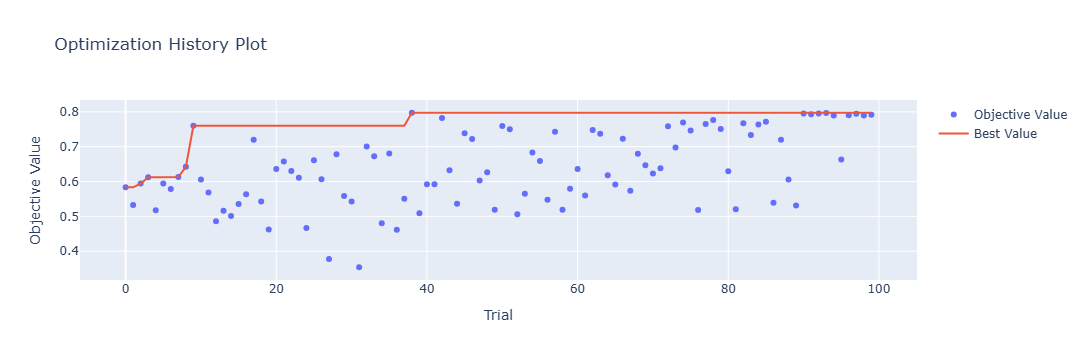

In [3]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.write_html("optimization_history_realistic.html")
fig1.show()

# Best Tuned Hyperparamter on Realistic Mode

In [4]:
print(study.best_value)
best_params

0.7974684234399261


{'smote_level': 'small',
 'C': 0.009211329264988676,
 'kernel': 'rbf',
 'gamma': 'auto',
 'max_iter': 4841}

# FINAL EVALUATION ON TEST (with both thresholds) for the Realistic Mode

In [5]:
# ==============================================================================
# FINAL EVALUATION ON TEST
# ==============================================================================

# Predict probabilities
y_test_pred_prop_svc = final_pipe_svm.predict_proba(X_test)[:, 1]


# find thresholds
thresholds_svc = {"F1": None, "Balanced_Accuracy": None}
best_f1_svc = 0
best_bal_svc = 0

for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop_svc >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)
    bal_t = balanced_accuracy_score(y_test, y_pred_t)

    if f1_t > best_f1_svc:
        best_f1_svc = f1_t
        thresholds_svc["F1"] = t
    if bal_t > best_bal_svc:
        best_bal_svc = bal_t
        thresholds_svc["Balanced_Accuracy"] = t

# predictions
y_pred_f1_svc = (y_test_pred_prop_svc >= thresholds_svc["F1"]).astype(int)
y_pred_bal_svc = (y_test_pred_prop_svc >= thresholds_svc["Balanced_Accuracy"]).astype(int)

# metrics dicts
metrics_f1_svc = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1_svc),
    "precision": precision_score(y_test, y_pred_f1_svc),
    "recall": recall_score(y_test, y_pred_f1_svc),
    "f1": f1_score(y_test, y_pred_f1_svc),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_svc),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1_svc),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1_svc),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1_svc)
}

metrics_bal_svc = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal_svc),
    "precision": precision_score(y_test, y_pred_bal_svc),
    "recall": recall_score(y_test, y_pred_bal_svc),
    "f1": f1_score(y_test, y_pred_bal_svc),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_svc),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal_svc),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal_svc),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal_svc)
}

# print SVC results
print("\nFINAL EVALUATION ON TEST SET (SVC)")
print("="*70)

print(f"\nUsing F1 Threshold ({thresholds_svc['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1_svc['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1_svc['precision']:.4f}")
print(f"Recall: {metrics_f1_svc['recall']:.4f}")
print(f"F1 Score: {metrics_f1_svc['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1_svc['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1_svc['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1_svc['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1_svc['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1_svc))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1_svc))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1_svc))

print(f"\nUsing Balanced Accuracy Threshold ({thresholds_svc['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal_svc['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal_svc['precision']:.4f}")
print(f"Recall: {metrics_bal_svc['recall']:.4f}")
print(f"F1 Score: {metrics_bal_svc['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal_svc['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal_svc['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal_svc['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal_svc['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_svc))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_svc))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal_svc))

best_params_svc = study.best_params
best_value_svc = study.best_value
study_svc = study

# Save SVC model dict
model_dict_svc = {
    "best_params": best_params_svc,
    "best_value": best_value_svc,
    "thresholds": thresholds_svc,
    "metrics_f1": metrics_f1_svc,
    "metrics_balanced_accuracy": metrics_bal_svc,
    "study": study_svc,
    "model": final_pipe_svm
}

joblib.dump(model_dict_svc, "SVC_realistic_model.pkl")


FINAL EVALUATION ON TEST SET (SVC)

Using F1 Threshold (0.900)
Balanced Accuracy: 0.7466
Precision: 0.0967
Recall: 0.7235
F1 Score: 0.1706
ROC-AUC: 0.7437
Geometric Mean: 0.7462
Matthews Corr: 0.2042
Cohen Kappa: 0.1194

Confusion Matrix:
 [[4902 1467]
 [  60  157]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87      6369
           1       0.10      0.72      0.17       217

    accuracy                           0.77      6586
   macro avg       0.54      0.75      0.52      6586
weighted avg       0.96      0.77      0.84      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.77      0.72      0.87      0.75      0.56      6369
          1       0.10      0.72      0.77      0.17      0.75      0.55       217

avg / total       0.96      0.77      0.73      0.84      0.75      0.56      6586


Using Balanced Accuracy

['SVC_realistic_model.pkl']

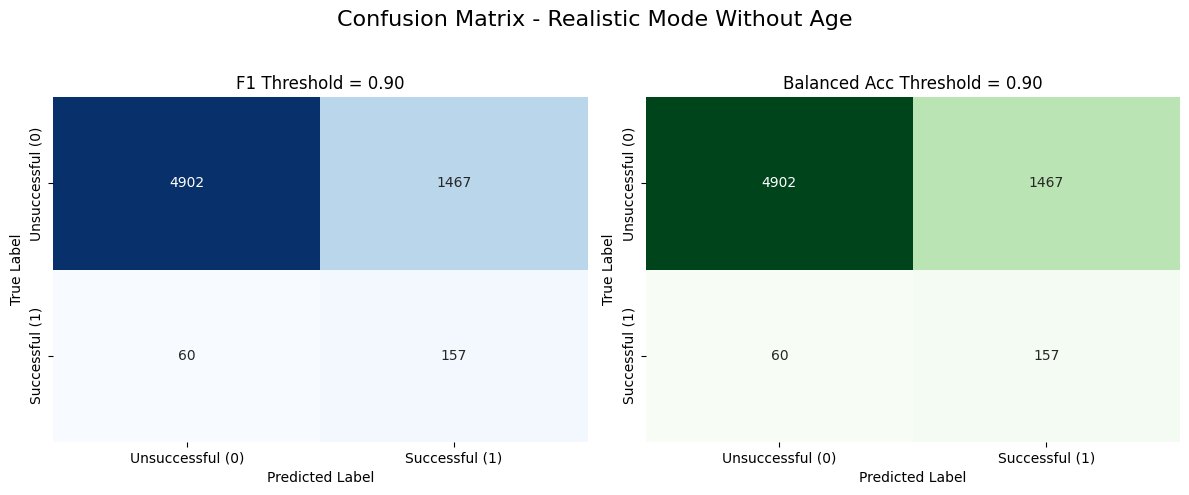

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1_svc)
cm_bal = confusion_matrix(y_test, y_pred_bal_svc)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  F1 Threshold 
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds_svc['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

#  Balanced Accuracy Threshold 
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds_svc['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Realistic Mode Without Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("Confusion Matrix - Realistic Mode")
plt.show()

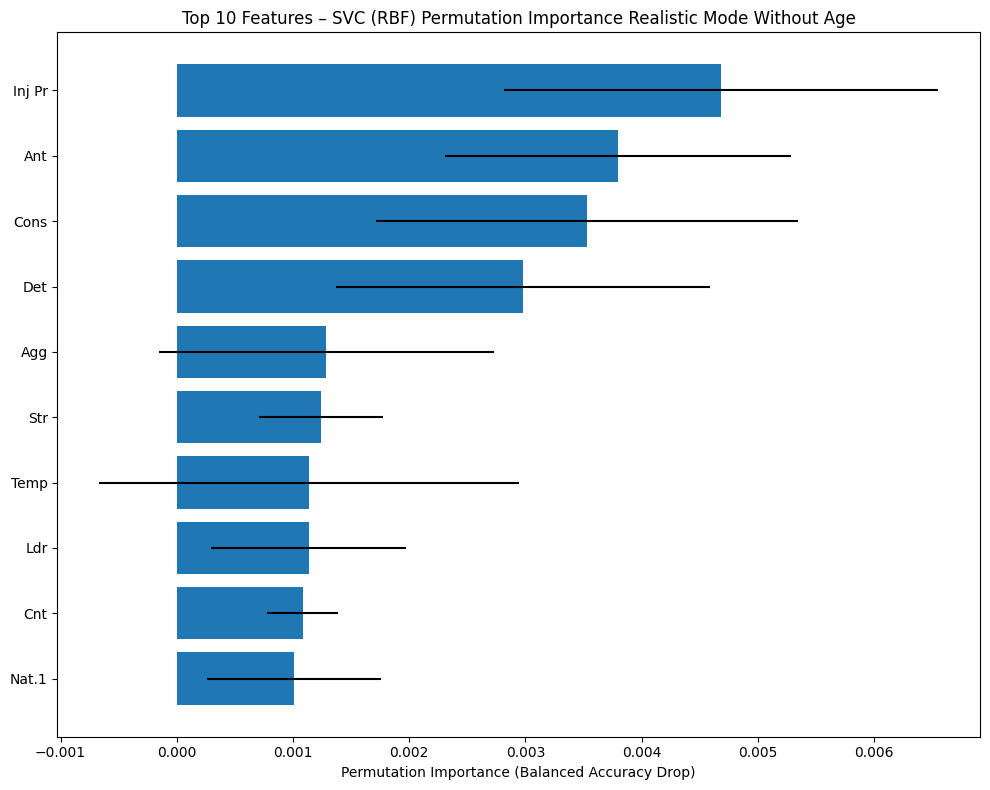

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

result = permutation_importance(
    final_pipe_svm,
    X_test,
    y_test,
    scoring="balanced_accuracy",
    n_repeats=5,
    random_state=SEED,
    n_jobs=-1
)

importances = result.importances_mean
std = result.importances_std
feature_names = np.array(X_test.columns)

# Sort importances
sorted_idx = np.argsort(importances)[::-1]

# Top N features
top_n = 10
top_idx = sorted_idx[:top_n]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_names[top_idx][::-1], importances[top_idx][::-1], xerr=std[top_idx][::-1])
plt.xlabel("Permutation Importance (Balanced Accuracy Drop)")
plt.title("Top 10 Features – SVC (RBF) Permutation Importance Realistic Mode Without Age")
plt.tight_layout()
plt.show()

# Data Configuration and Optimization (For Full Mode)

In [8]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import(
precision_recall_curve , recall_score , f1_score , balanced_accuracy_score ,
roc_auc_score , confusion_matrix , precision_score , classification_report ,
matthews_corrcoef , cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score , classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler


# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "full"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat', 'Age'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]


X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

def objective(trial):
    # SMOTE parameters
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

    # SVC parameters
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    max_iter = trial.suggest_int('max_iter', 1000, 5000)

    clf = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        max_iter=max_iter,
        probability=False,
        random_state=SEED
    )

    pipe = ImbPipeline([
        ("smote", smote),
        ('scaler', StandardScaler()),
        ("clf", clf)
    ])

    pipe.fit(X_train, y_train) # Trains the pipeline on the training set.
    y_val_pred = pipe.predict(X_val) # Predicts on the validation set. evaluating the model trained on the training set.
    return balanced_accuracy_score(y_val, y_val_pred)

# ==============================================================================
# RUN OPTUNA STUDY
# ==============================================================================

study = optuna.create_study(direction = "maximize" , study_name = "SVC_Full")
study.optimize(objective , n_trials = N_TRIALS , show_progress_bar = True)

best_params = study.best_params
print("\nBest Hyperparameters",best_params)

# ==============================================================================
# FINAL MODEL TRAINING
# ==============================================================================

best_params_svm = study.best_params
smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[best_params_svm['smote_level']]
best_smote_svm = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

svm_clf = SVC(
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma'],
    max_iter=best_params_svm['max_iter'],
    probability=True,
    random_state=SEED
)

final_pipe_svm = ImbPipeline([
    ("smote", best_smote_svm),
    ("scaler", StandardScaler()),
    ("clf", svm_clf)
])


X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])

final_pipe_svm.fit(X_train_final, y_train_final)

Reading file...


[I 2025-12-08 18:12:59,456] A new study created in memory with name: SVC_Full


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 66  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3331).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:13:16,788] Trial 0 finished with value: 0.434561504509691 and parameters: {'smote_level': 'medium', 'C': 0.0718412297279331, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3331}. Best is trial 0 with value: 0.434561504509691.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1914).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:13:27,084] Trial 1 finished with value: 0.6748072259730291 and parameters: {'smote_level': 'high', 'C': 0.08114601832833691, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1914}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2723).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:13:52,722] Trial 2 finished with value: 0.5968046178538406 and parameters: {'smote_level': 'high', 'C': 0.004080925806031268, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2723}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3255).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:14:12,990] Trial 3 finished with value: 0.5101282688717922 and parameters: {'smote_level': 'high', 'C': 0.013695779834690993, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3255}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4668).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:14:41,395] Trial 4 finished with value: 0.6468113780289946 and parameters: {'smote_level': 'medium', 'C': 3.920189287436485, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4668}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1189).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:14:51,232] Trial 5 finished with value: 0.5924246785645749 and parameters: {'smote_level': 'high', 'C': 269.5154649336637, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1189}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4684).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:15:22,306] Trial 6 finished with value: 0.6566583363863157 and parameters: {'smote_level': 'small', 'C': 0.11846027097638387, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4684}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2618).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:15:36,434] Trial 7 finished with value: 0.5286467873903107 and parameters: {'smote_level': 'small', 'C': 0.009301593766330373, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2618}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3449).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:15:55,151] Trial 8 finished with value: 0.6325299628408436 and parameters: {'smote_level': 'medium', 'C': 162.3761811189376, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3449}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1828).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:16:01,582] Trial 9 finished with value: 0.2860437274297378 and parameters: {'smote_level': 'medium', 'C': 654.9555144635367, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1828}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1777).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:16:10,162] Trial 10 finished with value: 0.5631367648854696 and parameters: {'smote_level': 'high', 'C': 3.033876347207692, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1777}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4969).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:16:35,913] Trial 11 finished with value: 0.6497923972017237 and parameters: {'smote_level': 'small', 'C': 0.19341962966828288, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4969}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4160).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:17:01,684] Trial 12 finished with value: 0.6431619737966888 and parameters: {'smote_level': 'small', 'C': 0.36849264907312285, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4160}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2194).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:17:10,697] Trial 13 finished with value: 0.4612979972435931 and parameters: {'smote_level': 'small', 'C': 0.0010596935127877387, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2194}. Best is trial 1 with value: 0.6748072259730291.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1052).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:17:18,745] Trial 14 finished with value: 0.6897145025383367 and parameters: {'smote_level': 'high', 'C': 15.563181148878678, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1052}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1078).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:17:24,325] Trial 15 finished with value: 0.5634409727673977 and parameters: {'smote_level': 'high', 'C': 14.901034346043476, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1078}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1482).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:17:31,743] Trial 16 finished with value: 0.5077752917778825 and parameters: {'smote_level': 'high', 'C': 36.25139211845056, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1482}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2112).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:17:50,020] Trial 17 finished with value: 0.6596371748573822 and parameters: {'smote_level': 'high', 'C': 1.4759563446194477, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2112}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1430).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:18:01,133] Trial 18 finished with value: 0.6410783133581061 and parameters: {'smote_level': 'high', 'C': 20.434983249969953, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1430}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2302).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:18:14,810] Trial 19 finished with value: 0.6637314422288516 and parameters: {'smote_level': 'high', 'C': 0.038128808073696424, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2302}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1021).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:18:23,098] Trial 20 finished with value: 0.6740625163552625 and parameters: {'smote_level': 'high', 'C': 6.721613358762431, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1021}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1041).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:18:31,994] Trial 21 finished with value: 0.6623499677256154 and parameters: {'smote_level': 'high', 'C': 0.9122204189391616, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1041}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1586).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:18:44,029] Trial 22 finished with value: 0.6331154812372429 and parameters: {'smote_level': 'high', 'C': 5.38908561391552, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1586}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1352).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:18:54,181] Trial 23 finished with value: 0.6549290399679001 and parameters: {'smote_level': 'high', 'C': 59.386495024141695, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1352}. Best is trial 14 with value: 0.6897145025383367.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1805).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:19:10,008] Trial 24 finished with value: 0.7136586067933218 and parameters: {'smote_level': 'high', 'C': 0.6610642569200974, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1805}. Best is trial 24 with value: 0.7136586067933218.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1909).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:19:26,015] Trial 25 finished with value: 0.7086255473561174 and parameters: {'smote_level': 'high', 'C': 0.5211320916313833, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1909}. Best is trial 24 with value: 0.7136586067933218.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2628).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:19:49,294] Trial 26 finished with value: 0.7240507405662846 and parameters: {'smote_level': 'high', 'C': 0.4338851696178659, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2628}. Best is trial 26 with value: 0.7240507405662846.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2631).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:20:11,909] Trial 27 finished with value: 0.6729383646482092 and parameters: {'smote_level': 'high', 'C': 0.638102609239351, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2631}. Best is trial 26 with value: 0.7240507405662846.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2916).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:20:32,848] Trial 28 finished with value: 0.7032195879346138 and parameters: {'smote_level': 'medium', 'C': 0.31884213127020977, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2916}. Best is trial 26 with value: 0.7240507405662846.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3621).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:21:06,652] Trial 29 finished with value: 0.5772142844681705 and parameters: {'smote_level': 'high', 'C': 0.02766919181213589, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3621}. Best is trial 26 with value: 0.7240507405662846.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2410).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:21:23,885] Trial 30 finished with value: 0.6798828090926536 and parameters: {'smote_level': 'medium', 'C': 1.1556774404785242, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2410}. Best is trial 26 with value: 0.7240507405662846.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3034).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:21:45,482] Trial 31 finished with value: 0.7287970377348616 and parameters: {'smote_level': 'medium', 'C': 0.25500160131312366, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3034}. Best is trial 31 with value: 0.7287970377348616.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2911).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:22:05,904] Trial 32 finished with value: 0.6676588859231347 and parameters: {'smote_level': 'medium', 'C': 0.06886385013846792, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2911}. Best is trial 31 with value: 0.7287970377348616.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3145).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:22:27,697] Trial 33 finished with value: 0.7466406290888157 and parameters: {'smote_level': 'medium', 'C': 0.20500935970980808, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3145}. Best is trial 33 with value: 0.7466406290888157.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3844).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:22:57,066] Trial 34 finished with value: 0.7360555032187157 and parameters: {'smote_level': 'medium', 'C': 0.15677798098668716, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3844}. Best is trial 33 with value: 0.7466406290888157.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3853).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:23:27,036] Trial 35 finished with value: 0.7570240400551281 and parameters: {'smote_level': 'medium', 'C': 0.09010402700116216, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3853}. Best is trial 35 with value: 0.7570240400551281.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3887).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:23:56,875] Trial 36 finished with value: 0.7701725807295756 and parameters: {'smote_level': 'medium', 'C': 0.09217245296179331, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3887}. Best is trial 36 with value: 0.7701725807295756.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3840).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:24:26,796] Trial 37 finished with value: 0.5384305053994173 and parameters: {'smote_level': 'medium', 'C': 0.009580667378322158, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3840}. Best is trial 36 with value: 0.7701725807295756.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4127).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:24:57,752] Trial 38 finished with value: 0.7215810959334276 and parameters: {'smote_level': 'medium', 'C': 0.1088128475842308, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4127}. Best is trial 36 with value: 0.7701725807295756.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4030).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:25:28,705] Trial 39 finished with value: 0.623142042183493 and parameters: {'smote_level': 'medium', 'C': 0.025460213350649855, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4030}. Best is trial 36 with value: 0.7701725807295756.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4370).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:26:01,421] Trial 40 finished with value: 0.7751881945534795 and parameters: {'smote_level': 'medium', 'C': 0.06228590675033509, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4370}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4350).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:26:34,064] Trial 41 finished with value: 0.7737347568953786 and parameters: {'smote_level': 'medium', 'C': 0.06305913379106677, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4350}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4534).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:27:09,757] Trial 42 finished with value: 0.54698757872333 and parameters: {'smote_level': 'medium', 'C': 0.004136316869520191, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4534}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4458).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:27:42,832] Trial 43 finished with value: 0.7353892988608015 and parameters: {'smote_level': 'medium', 'C': 0.09030874309923953, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4458}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4335).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:28:16,551] Trial 44 finished with value: 0.7716085727743759 and parameters: {'smote_level': 'medium', 'C': 0.050523981149230186, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4335}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4383).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:28:50,548] Trial 45 finished with value: 0.774616850717887 and parameters: {'smote_level': 'medium', 'C': 0.04301028754392111, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4383}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4962).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:29:29,441] Trial 46 finished with value: 0.7711015596378291 and parameters: {'smote_level': 'medium', 'C': 0.04109322300509948, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4962}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4942).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:30:08,923] Trial 47 finished with value: 0.5345837476666492 and parameters: {'smote_level': 'medium', 'C': 0.004525568438375042, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4942}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4372).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:30:28,035] Trial 48 finished with value: 0.6977580206207149 and parameters: {'smote_level': 'medium', 'C': 0.046700664192874726, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4372}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4709).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:31:03,394] Trial 49 finished with value: 0.6517561190488652 and parameters: {'smote_level': 'medium', 'C': 0.01854737042708289, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4709}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4308).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:31:31,221] Trial 50 finished with value: 0.6271414490326408 and parameters: {'smote_level': 'small', 'C': 0.001879559833882448, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4308}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4815).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:32:08,110] Trial 51 finished with value: 0.5988817361874357 and parameters: {'smote_level': 'medium', 'C': 0.014116474571053484, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4815}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4624).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:32:42,518] Trial 52 finished with value: 0.7723598244971301 and parameters: {'smote_level': 'medium', 'C': 0.050762587784626494, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4624}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4572).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:33:17,278] Trial 53 finished with value: 0.7731405156923292 and parameters: {'smote_level': 'medium', 'C': 0.04947022380861083, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4572}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4569).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:33:52,699] Trial 54 finished with value: 0.5286958531777185 and parameters: {'smote_level': 'medium', 'C': 0.006925505091860493, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4569}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4228).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:34:14,779] Trial 55 finished with value: 0.754138971755552 and parameters: {'smote_level': 'medium', 'C': 0.017369895032622627, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4228}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4682).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:34:49,285] Trial 56 finished with value: 0.7688717921878544 and parameters: {'smote_level': 'medium', 'C': 0.055742649036807916, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4682}. Best is trial 40 with value: 0.7751881945534795.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4059).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:35:15,276] Trial 57 finished with value: 0.794852671795677 and parameters: {'smote_level': 'small', 'C': 0.026888857766375666, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4059}. Best is trial 57 with value: 0.794852671795677.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3522).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:35:37,343] Trial 58 finished with value: 0.5568792414647337 and parameters: {'smote_level': 'small', 'C': 0.010493036534563193, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3522}. Best is trial 57 with value: 0.794852671795677.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4056).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:35:55,945] Trial 59 finished with value: 0.7773699865668777 and parameters: {'smote_level': 'small', 'C': 0.0021375536464274297, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4056}. Best is trial 57 with value: 0.794852671795677.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3668).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:36:12,918] Trial 60 finished with value: 0.7868091537132988 and parameters: {'smote_level': 'small', 'C': 0.0019743505999433595, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3668}. Best is trial 57 with value: 0.794852671795677.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4104).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:36:32,893] Trial 61 finished with value: 0.7614039793443939 and parameters: {'smote_level': 'small', 'C': 0.002165797345916536, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4104}. Best is trial 57 with value: 0.794852671795677.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3991).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:36:50,926] Trial 62 finished with value: 0.7966114076865372 and parameters: {'smote_level': 'small', 'C': 0.0010233702578934254, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3991}. Best is trial 62 with value: 0.7966114076865372.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4033).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:37:09,343] Trial 63 finished with value: 0.7933632525601437 and parameters: {'smote_level': 'small', 'C': 0.0011501462532734132, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4033}. Best is trial 62 with value: 0.7966114076865372.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3953).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:37:27,716] Trial 64 finished with value: 0.7976635962387257 and parameters: {'smote_level': 'small', 'C': 0.0010286067920997988, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3953}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3630).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:37:43,526] Trial 65 finished with value: 0.707305132499433 and parameters: {'smote_level': 'small', 'C': 0.0011894758346599325, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3630}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4021).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:38:01,580] Trial 66 finished with value: 0.7434371783465048 and parameters: {'smote_level': 'small', 'C': 0.002219729568044829, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4021}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3346).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:38:16,587] Trial 67 finished with value: 0.5839330262905392 and parameters: {'smote_level': 'small', 'C': 0.0011375815648165628, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3346}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3716).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:38:32,690] Trial 68 finished with value: 0.7862977791734268 and parameters: {'smote_level': 'small', 'C': 0.0029843404705954192, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3716}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3702).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:38:48,631] Trial 69 finished with value: 0.7774463111250676 and parameters: {'smote_level': 'small', 'C': 0.002987830233187786, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3702}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3656).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:39:04,437] Trial 70 finished with value: 0.7833909038572251 and parameters: {'smote_level': 'small', 'C': 0.006164919014729553, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3656}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3691).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:39:21,012] Trial 71 finished with value: 0.7924124666352645 and parameters: {'smote_level': 'small', 'C': 0.003195542587471176, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3691}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3415).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:39:35,865] Trial 72 finished with value: 0.7871635177334659 and parameters: {'smote_level': 'small', 'C': 0.004515808285346991, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3415}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3421).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:39:50,780] Trial 73 finished with value: 0.7917582561364944 and parameters: {'smote_level': 'small', 'C': 0.0016699576514498497, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3421}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3416).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:40:05,300] Trial 74 finished with value: 0.6104743462256416 and parameters: {'smote_level': 'small', 'C': 0.0014456599822470896, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3416}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3245).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:40:19,353] Trial 75 finished with value: 0.7766198251949548 and parameters: {'smote_level': 'small', 'C': 0.006129470216283105, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3245}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3496).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:40:35,545] Trial 76 finished with value: 0.6098037804644022 and parameters: {'smote_level': 'small', 'C': 0.0010056766955329924, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3496}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3937).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:40:53,055] Trial 77 finished with value: 0.7687387693864378 and parameters: {'smote_level': 'small', 'C': 0.0032847450585229126, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3937}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3753).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:41:09,503] Trial 78 finished with value: 0.7920744578775667 and parameters: {'smote_level': 'small', 'C': 0.0018848500255164188, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3753}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3766).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:41:26,611] Trial 79 finished with value: 0.7943107674325292 and parameters: {'smote_level': 'small', 'C': 0.0014698220951476005, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3766}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3969).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:41:45,474] Trial 80 finished with value: 0.7928834981943791 and parameters: {'smote_level': 'small', 'C': 0.0014344302470302947, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3969}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3804).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:42:02,919] Trial 81 finished with value: 0.786528933549659 and parameters: {'smote_level': 'small', 'C': 0.0018431543813330466, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3804}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4204).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:42:22,874] Trial 82 finished with value: 0.7963508138378604 and parameters: {'smote_level': 'small', 'C': 0.0012424023487878143, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4204}. Best is trial 64 with value: 0.7976635962387257.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4225).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:42:43,839] Trial 83 finished with value: 0.7977213848327838 and parameters: {'smote_level': 'small', 'C': 0.0010146370341889716, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4225}. Best is trial 83 with value: 0.7977213848327838.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4195).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:43:02,915] Trial 84 finished with value: 0.8032570960032099 and parameters: {'smote_level': 'small', 'C': 0.001000617764529855, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4195}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3931).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:43:21,333] Trial 85 finished with value: 0.7817455644528184 and parameters: {'smote_level': 'small', 'C': 0.0012167635282261098, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3931}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4216).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:43:41,434] Trial 86 finished with value: 0.8032505538982223 and parameters: {'smote_level': 'small', 'C': 0.0014346940385409977, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4216}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4179).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:44:00,603] Trial 87 finished with value: 0.7879954554177352 and parameters: {'smote_level': 'small', 'C': 0.0010395917793864869, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4179}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4247).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:44:21,504] Trial 88 finished with value: 0.7567765304164268 and parameters: {'smote_level': 'small', 'C': 0.0026691282907091167, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4247}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4479).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:44:43,027] Trial 89 finished with value: 0.7279825456638929 and parameters: {'smote_level': 'small', 'C': 0.005003558216822514, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4479}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4139).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:45:02,611] Trial 90 finished with value: 0.7878787878787878 and parameters: {'smote_level': 'small', 'C': 0.0014200475463730026, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4139}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3991).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:45:20,948] Trial 91 finished with value: 0.7920559219134349 and parameters: {'smote_level': 'small', 'C': 0.0014255359412835948, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3991}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4195).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:45:39,696] Trial 92 finished with value: 0.7082886289492507 and parameters: {'smote_level': 'small', 'C': 0.0077254318163712315, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4195}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3917).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:45:58,773] Trial 93 finished with value: 0.7958601559637829 and parameters: {'smote_level': 'small', 'C': 0.0010128397369085088, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3917}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4268).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:46:19,732] Trial 94 finished with value: 0.7519517279879975 and parameters: {'smote_level': 'small', 'C': 0.0024726509282551883, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4268}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4114).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:46:38,502] Trial 95 finished with value: 0.7748578182516006 and parameters: {'smote_level': 'small', 'C': 0.003715834083630618, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4114}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4441).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:46:48,936] Trial 96 finished with value: 0.43705949826416146 and parameters: {'smote_level': 'small', 'C': 522.6441193006129, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4441}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3812).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:47:06,071] Trial 97 finished with value: 0.7236004256729645 and parameters: {'smote_level': 'small', 'C': 0.0010062987176671645, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3812}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4058).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:47:26,223] Trial 98 finished with value: 0.7892515395753738 and parameters: {'smote_level': 'small', 'C': 0.0015023077656426682, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4058}. Best is trial 84 with value: 0.8032570960032099.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3941).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 18:47:44,674] Trial 99 finished with value: 0.7829351372097486 and parameters: {'smote_level': 'small', 'C': 0.0026865503301040008, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3941}. Best is trial 84 with value: 0.8032570960032099.

Best Hyperparameters {'smote_level': 'small', 'C': 0.001000617764529855, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4195}


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4195).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,copy,True
,with_mean,True
,with_std,True
,C,0.001000617764529855


# Plot The Visualization History for the Optuna Full Mode

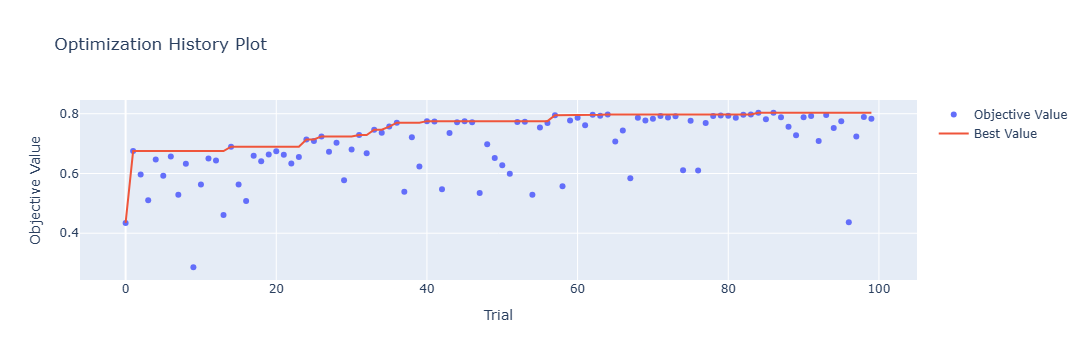

In [9]:
fig2 = optuna.visualization.plot_optimization_history(study)
fig2.write_html("optimization_history_full.html")
fig2.show()

# Best Tuned Hyperparamter on Full Mode

In [10]:
print(study.best_value)
best_params

0.8032570960032099


{'smote_level': 'small',
 'C': 0.001000617764529855,
 'kernel': 'linear',
 'gamma': 'scale',
 'max_iter': 4195}

# FINAL EVALUATION ON TEST (with both thresholds) for the Full Mode

In [11]:
# ==============================================================================
# FINAL EVALUATION ON TEST
# ==============================================================================

# Predict probabilities
y_test_pred_prop_svc = final_pipe_svm.predict_proba(X_test)[:, 1]


# find thresholds
thresholds_svc = {"F1": None, "Balanced_Accuracy": None}
best_f1_svc = 0
best_bal_svc = 0

for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop_svc >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)
    bal_t = balanced_accuracy_score(y_test, y_pred_t)

    if f1_t > best_f1_svc:
        best_f1_svc = f1_t
        thresholds_svc["F1"] = t
    if bal_t > best_bal_svc:
        best_bal_svc = bal_t
        thresholds_svc["Balanced_Accuracy"] = t

# predictions
y_pred_f1_svc = (y_test_pred_prop_svc >= thresholds_svc["F1"]).astype(int)
y_pred_bal_svc = (y_test_pred_prop_svc >= thresholds_svc["Balanced_Accuracy"]).astype(int)

# metrics dicts
metrics_f1_svc = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1_svc),
    "precision": precision_score(y_test, y_pred_f1_svc),
    "recall": recall_score(y_test, y_pred_f1_svc),
    "f1": f1_score(y_test, y_pred_f1_svc),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_svc),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1_svc),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1_svc),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1_svc)
}

metrics_bal_svc = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal_svc),
    "precision": precision_score(y_test, y_pred_bal_svc),
    "recall": recall_score(y_test, y_pred_bal_svc),
    "f1": f1_score(y_test, y_pred_bal_svc),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_svc),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal_svc),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal_svc),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal_svc)
}

# print SVC results
print("\nFINAL EVALUATION ON TEST SET (SVC)")
print("="*70)

print(f"\nUsing F1 Threshold ({thresholds_svc['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1_svc['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1_svc['precision']:.4f}")
print(f"Recall: {metrics_f1_svc['recall']:.4f}")
print(f"F1 Score: {metrics_f1_svc['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1_svc['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1_svc['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1_svc['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1_svc['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1_svc))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1_svc))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1_svc))

print(f"\nUsing Balanced Accuracy Threshold ({thresholds_svc['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal_svc['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal_svc['precision']:.4f}")
print(f"Recall: {metrics_bal_svc['recall']:.4f}")
print(f"F1 Score: {metrics_bal_svc['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal_svc['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal_svc['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal_svc['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal_svc['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_svc))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_svc))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal_svc))

best_params_svc = study.best_params
best_value_svc = study.best_value
study_svc = study

# Save SVC model dict
model_dict_svc = {
    "best_params": best_params_svc,
    "best_value": best_value_svc,
    "thresholds": thresholds_svc,
    "metrics_f1": metrics_f1_svc,
    "metrics_balanced_accuracy": metrics_bal_svc,
    "study": study_svc,
    "model": final_pipe_svm
}

joblib.dump(model_dict_svc, "SVC_full_model.pkl")


FINAL EVALUATION ON TEST SET (SVC)

Using F1 Threshold (0.900)
Balanced Accuracy: 0.7674
Precision: 0.1121
Recall: 0.7327
F1 Score: 0.1944
ROC-AUC: 0.8368
Geometric Mean: 0.7667
Matthews Corr: 0.2322
Cohen Kappa: 0.1455

Confusion Matrix:
 [[5109 1260]
 [  58  159]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.89      6369
           1       0.11      0.73      0.19       217

    accuracy                           0.80      6586
   macro avg       0.55      0.77      0.54      6586
weighted avg       0.96      0.80      0.86      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.80      0.73      0.89      0.77      0.59      6369
          1       0.11      0.73      0.80      0.19      0.77      0.58       217

avg / total       0.96      0.80      0.74      0.86      0.77      0.59      6586


Using Balanced Accuracy

['SVC_full_model.pkl']

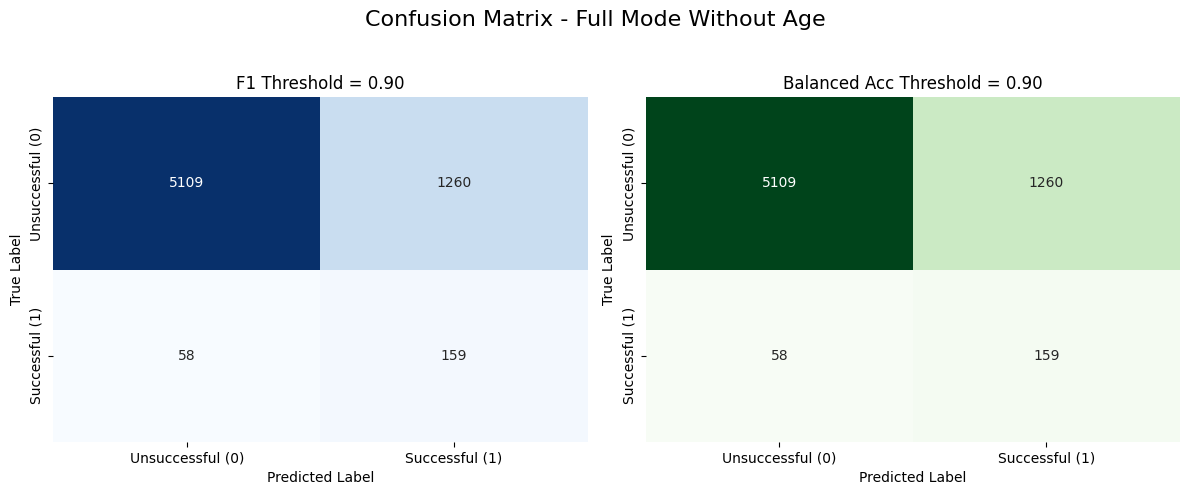

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1_svc)
cm_bal = confusion_matrix(y_test, y_pred_bal_svc)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  F1 Threshold 
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds_svc['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

#  Balanced Accuracy Threshold 
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds_svc['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Full Mode Without Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("Confusion Matrix - Full Mode")
plt.show()

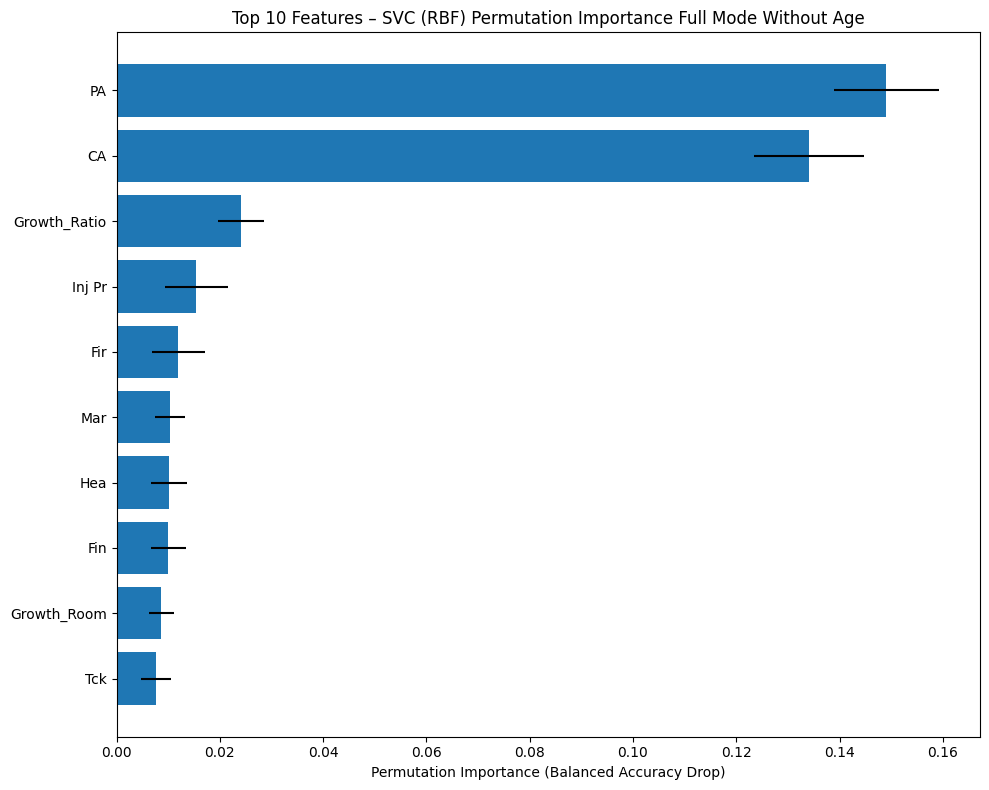

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

result = permutation_importance(
    final_pipe_svm,
    X_test,
    y_test,
    scoring="balanced_accuracy",
    n_repeats=5,
    random_state=SEED,
    n_jobs=-1
)

importances = result.importances_mean
std = result.importances_std
feature_names = np.array(X_test.columns)

# Sort importances
sorted_idx = np.argsort(importances)[::-1]

# Top N features
top_n = 10
top_idx = sorted_idx[:top_n]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_names[top_idx][::-1], importances[top_idx][::-1], xerr=std[top_idx][::-1])
plt.xlabel("Permutation Importance (Balanced Accuracy Drop)")
plt.title("Top 10 Features – SVC (RBF) Permutation Importance Full Mode Without Age")
plt.tight_layout()
plt.show()

# visualize the comparison of the models based on different metrics.

In [14]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import joblib

# Load the realistic mode model
svc_realistic_model = joblib.load("SVC_realistic_model.pkl")

# Load the full mode model
svc_full_model = joblib.load("SVC_full_model.pkl")

print("Realistic Model Metrics (F1 Optimal Threshold):")
print(svc_realistic_model['metrics_f1'])

print("\nFull Model Metrics (F1 Optimal Threshold):")
print(svc_full_model['metrics_f1'])

print("\nRealistic Model Metrics (Balanced Accuracy Optimal Threshold):")
print(svc_realistic_model['metrics_balanced_accuracy'])

print("\nFull Model Metrics (Balanced Accuracy Optimal Threshold):")
print(svc_full_model['metrics_balanced_accuracy'])

Realistic Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.7465839358702471, 'precision': 0.09667487684729065, 'recall': 0.7235023041474654, 'f1': 0.17055947854426942, 'roc_auc': 0.743651022775208, 'geometric_mean': np.float64(0.746227050954683), 'matthews_corrcoef': 0.20423909383976288, 'cohen_kappa': 0.11936837183154836}

Full Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.7674428195905716, 'precision': 0.11205073995771671, 'recall': 0.7327188940092166, 'f1': 0.19437652811735942, 'roc_auc': 0.8368494283587046, 'geometric_mean': np.float64(0.7666568530531421), 'matthews_corrcoef': 0.23222875870007154, 'cohen_kappa': 0.14553832372758724}

Realistic Model Metrics (Balanced Accuracy Optimal Threshold):
{'balanced_accuracy': 0.7465839358702471, 'precision': 0.09667487684729065, 'recall': 0.7235023041474654, 'f1': 0.17055947854426942, 'roc_auc': 0.743651022775208, 'geometric_mean': np.float64(0.746227050954683), 'matthews_corrcoef': 0.20423909383976288, 'cohen_k

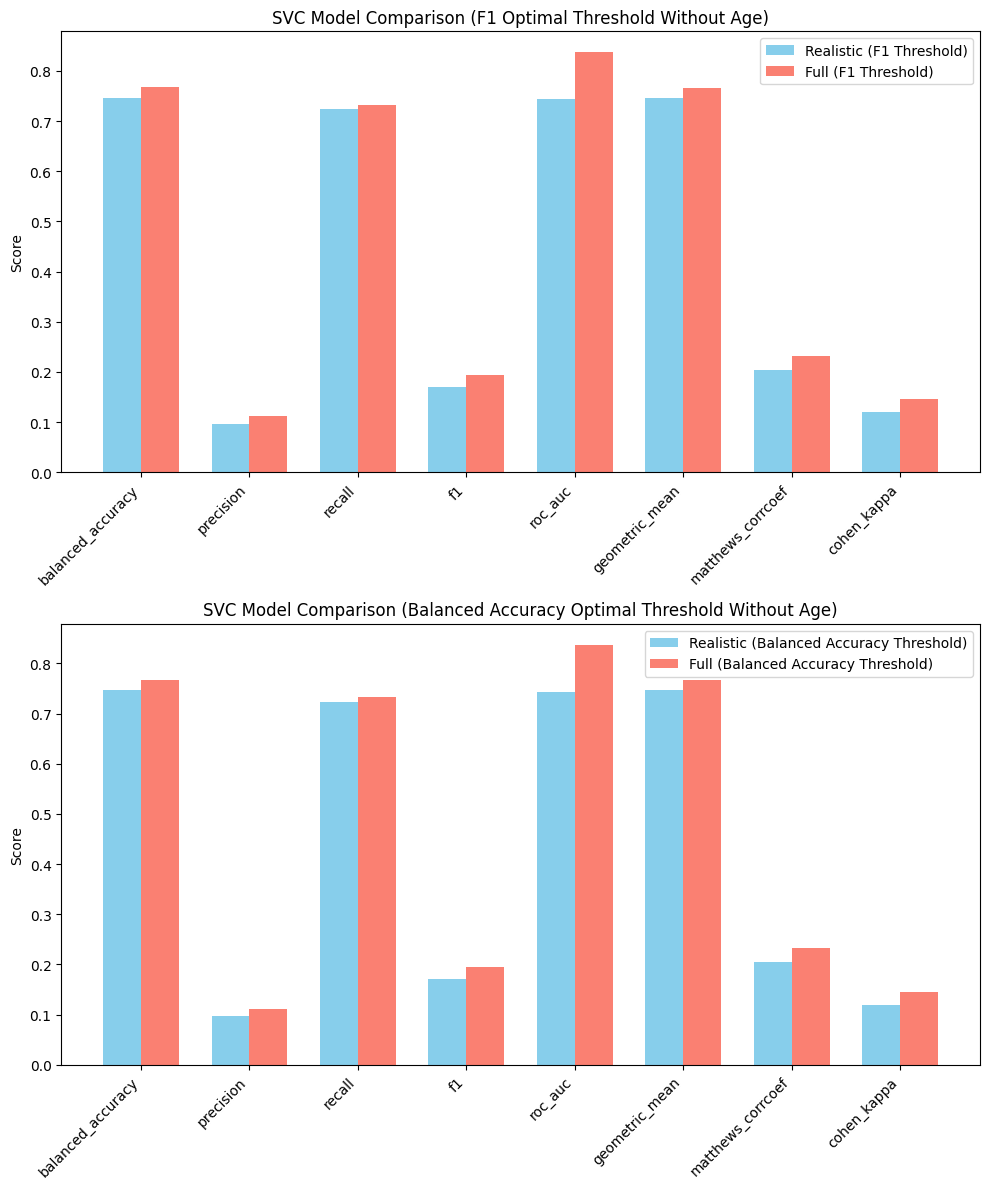

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract metrics for comparison
metrics_f1_realistic = svc_realistic_model['metrics_f1']
metrics_f1_full = svc_full_model['metrics_f1']
metrics_bal_realistic = svc_realistic_model['metrics_balanced_accuracy']
metrics_bal_full = svc_full_model['metrics_balanced_accuracy']

# Create DataFrames for easier plotting
df_f1 = pd.DataFrame({
    "Metric": metrics_f1_realistic.keys(),
    "Realistic (F1 Threshold)": metrics_f1_realistic.values(),
    "Full (F1 Threshold)": metrics_f1_full.values()
})

df_bal = pd.DataFrame({
    "Metric": metrics_bal_realistic.keys(),
    "Realistic (Balanced Accuracy Threshold)": metrics_bal_realistic.values(),
    "Full (Balanced Accuracy Threshold)": metrics_bal_full.values()
})

# Create a 2x1 grid of plots
fig, axes = plt.subplots(2, 1, figsize=(10, 12)) 

# Plotting F1-optimal threshold metrics in the first subplot
bar_width = 0.35
x_f1 = np.arange(len(df_f1["Metric"]))

rects1_f1 = axes[0].bar(x_f1 - bar_width/2, df_f1["Realistic (F1 Threshold)"], bar_width, label='Realistic (F1 Threshold)', color='skyblue')
rects2_f1 = axes[0].bar(x_f1 + bar_width/2, df_f1["Full (F1 Threshold)"], bar_width, label='Full (F1 Threshold)', color='salmon')

axes[0].set_ylabel("Score")
axes[0].set_title("SVC Model Comparison (F1 Optimal Threshold Without Age)") 
axes[0].set_xticks(x_f1)
axes[0].set_xticklabels(df_f1["Metric"], rotation=45, ha='right')
axes[0].legend()

bar_width = 0.35
x_bal = np.arange(len(df_bal["Metric"]))

rects1_bal = axes[1].bar(x_bal - bar_width/2, df_bal["Realistic (Balanced Accuracy Threshold)"], bar_width, label='Realistic (Balanced Accuracy Threshold)', color='skyblue')
rects2_bal = axes[1].bar(x_bal + bar_width/2, df_bal["Full (Balanced Accuracy Threshold)"], bar_width, label='Full (Balanced Accuracy Threshold)', color='salmon')

axes[1].set_ylabel("Score")
axes[1].set_title("SVC Model Comparison (Balanced Accuracy Optimal Threshold Without Age)") 
axes[1].set_xticks(x_bal)
axes[1].set_xticklabels(df_bal["Metric"], rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
# Save the combined 2x1 plot
plt.savefig("svc_model_comparison_2x1_grid.png") 
plt.show()

SVC models loaded successfully.
Reading file...
Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 66  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


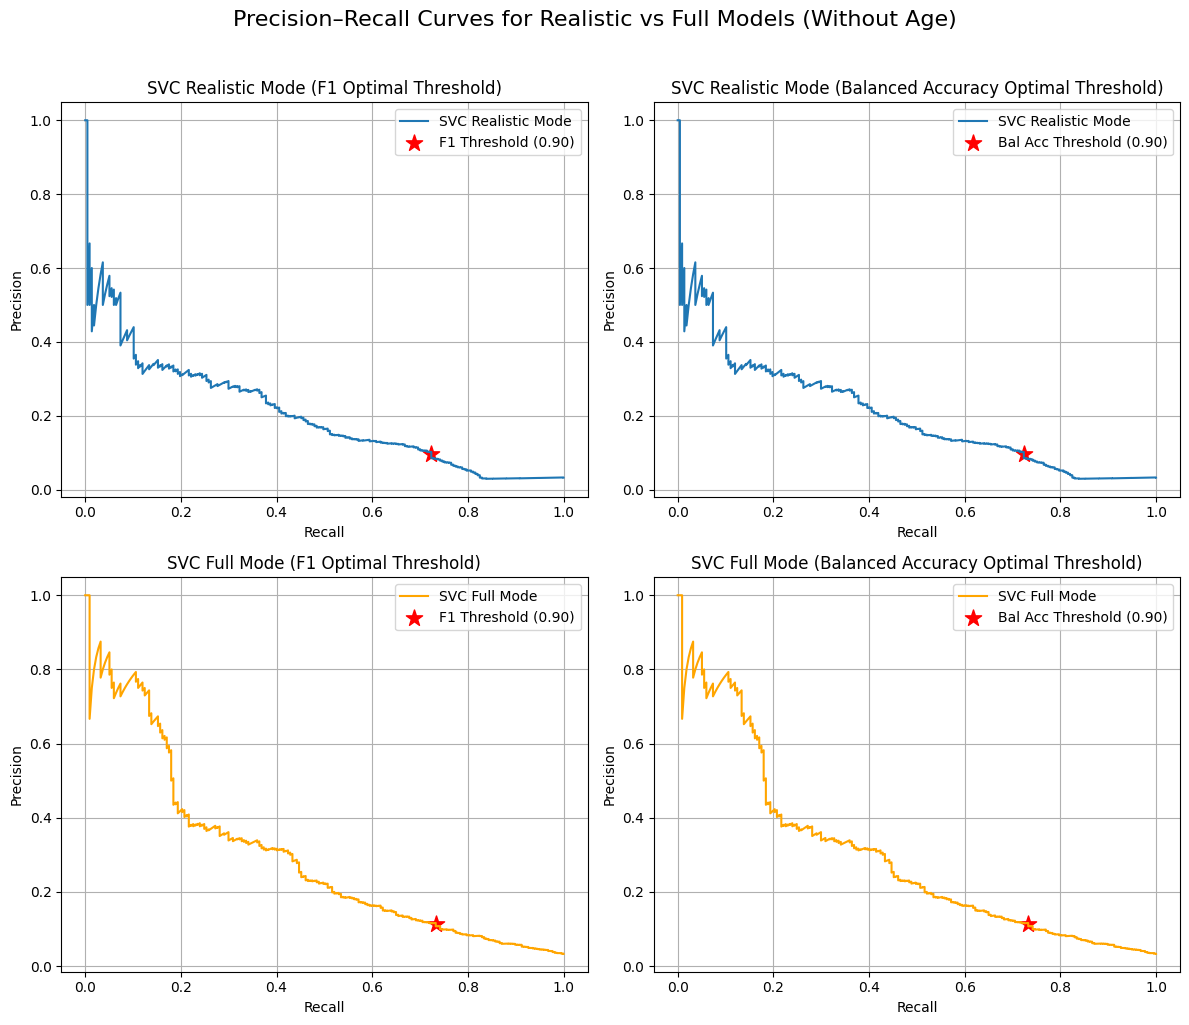

In [17]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import joblib 

# ==============================================================================
# CONFIGURATION
# ==============================================================================
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"

# ==============================================================================
# Load SVC Models
# ==============================================================================
# Assuming this part would be present in the final script execution environment
try:
    svc_realistic_model = joblib.load("SVC_realistic_model.pkl")
    svc_full_model = joblib.load("SVC_full_model.pkl")
    print("SVC models loaded successfully.")
except FileNotFoundError:
    print("Model files (SVC_realistic_model.pkl or SVC_full_model.pkl) not found. Plotting will fail.")


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat', "Age"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

MODE = "full" 
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# Separate X_test for realistic and full models
X_test_realistic = X_test.drop(columns=[c for c in ["CA", "PA", "Growth_Ratio", "Growth_Room"] if c in X_test.columns], errors='ignore')
X_test_full = X_test.copy()


# ==============================================================================
# Plotting Precision-Recall Curves (2x2 Grid)
# ==============================================================================

# Get predicted probabilities for the test set for both models
y_test_pred_prop_realistic = svc_realistic_model['model'].predict_proba(X_test_realistic)[:, 1]
y_test_pred_prop_full = svc_full_model['model'].predict_proba(X_test_full)[:, 1]

# Calculate precision and recall for different thresholds for realistic model
precision_realistic, recall_realistic, thresholds_realistic = precision_recall_curve(y_test, y_test_pred_prop_realistic)

# Calculate precision and recall for different thresholds for full model
precision_full, recall_full, thresholds_full = precision_recall_curve(y_test, y_test_pred_prop_full)

# Get the optimal thresholds from the loaded models
f1_threshold_realistic = svc_realistic_model['thresholds']['F1']
bal_acc_threshold_realistic = svc_realistic_model['thresholds']['Balanced_Accuracy']
f1_threshold_full = svc_full_model['thresholds']['F1']
bal_acc_threshold_full = svc_full_model['thresholds']['Balanced_Accuracy']

# Find the precision and recall values at the optimal thresholds
f1_idx_realistic = np.argmax(thresholds_realistic >= f1_threshold_realistic) if np.any(thresholds_realistic >= f1_threshold_realistic) else len(thresholds_realistic) - 1
f1_precision_realistic = precision_realistic[f1_idx_realistic]
f1_recall_realistic = recall_realistic[f1_idx_realistic]

bal_acc_idx_realistic = np.argmax(thresholds_realistic >= bal_acc_threshold_realistic) if np.any(thresholds_realistic >= bal_acc_threshold_realistic) else len(thresholds_realistic) - 1
bal_acc_precision_realistic = precision_realistic[bal_acc_idx_realistic]
bal_acc_recall_realistic = recall_realistic[bal_acc_idx_realistic]

f1_idx_full = np.argmax(thresholds_full >= f1_threshold_full) if np.any(thresholds_full >= f1_threshold_full) else len(thresholds_full) - 1
f1_precision_full = precision_full[f1_idx_full]
f1_recall_full = recall_full[f1_idx_full]

bal_acc_idx_full = np.argmax(thresholds_full >= bal_acc_threshold_full) if np.any(thresholds_full >= bal_acc_threshold_full) else len(thresholds_full) - 1
bal_acc_precision_full = precision_full[bal_acc_idx_full]
bal_acc_recall_full = recall_full[bal_acc_idx_full]


# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Realistic Mode (F1 Threshold)
axes[0, 0].plot(recall_realistic, precision_realistic, label='SVC Realistic Mode', linestyle='-') 
axes[0, 0].scatter(f1_recall_realistic, f1_precision_realistic, color='red', marker='*', s=150,
                   label=f'F1 Threshold ({f1_threshold_realistic:.2f})')
axes[0, 0].set_xlabel("Recall")
axes[0, 0].set_ylabel("Precision")
axes[0, 0].set_title("SVC Realistic Mode (F1 Optimal Threshold)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot Realistic Mode (Balanced Accuracy Threshold)
axes[0, 1].plot(recall_realistic, precision_realistic, label='SVC Realistic Mode', linestyle='-')  
axes[0, 1].scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='red', marker='*', s=150,
                   label=f'Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("SVC Realistic Mode (Balanced Accuracy Optimal Threshold)") 
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Full Mode (F1 Threshold)
axes[1, 0].plot(recall_full, precision_full, label='SVC Full Mode', color='orange', linestyle='-')  
axes[1, 0].scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
                   label=f'F1 Threshold ({f1_threshold_full:.2f})')
axes[1, 0].set_xlabel("Recall")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].set_title("SVC Full Mode (F1 Optimal Threshold)") 
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Full Mode (Balanced Accuracy Threshold)
axes[1, 1].plot(recall_full, precision_full, label='SVC Full Mode', color='orange', linestyle='-')  
axes[1, 1].scatter(bal_acc_recall_full, bal_acc_precision_full, color='red', marker='*', s=150,
                   label=f'Bal Acc Threshold ({bal_acc_threshold_full:.2f})')
axes[1, 1].set_xlabel("Recall")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].set_title("SVC Full Mode (Balanced Accuracy Optimal Threshold)") 
axes[1, 1].legend()
axes[1, 1].grid(True)

fig.suptitle(
    "Precision–Recall Curves for Realistic vs Full Models (Without Age)",
    fontsize=16,
    y=1.02
)

plt.tight_layout()
plt.savefig("svc_precision_recall_4grid.png")  
plt.show()

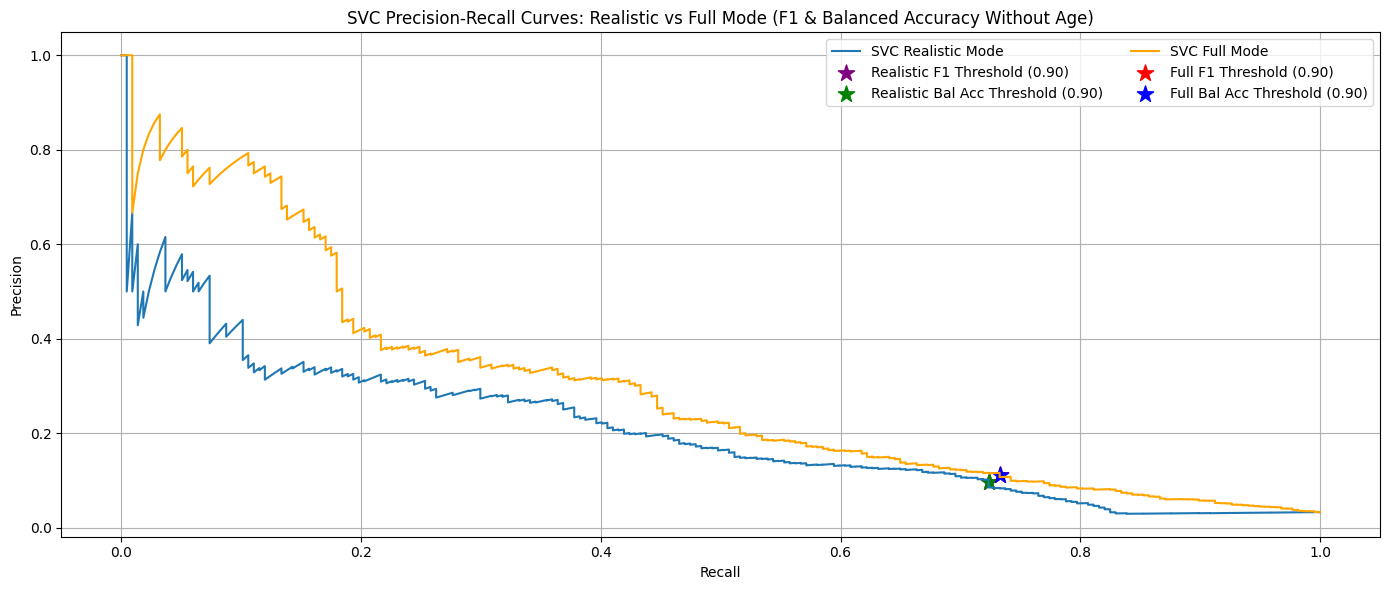

In [18]:
plt.figure(figsize=(14, 6))

#  SVC Realistic Mode 
plt.plot(recall_realistic, precision_realistic, label='SVC Realistic Mode', linestyle='-') 
plt.scatter(f1_recall_realistic, f1_precision_realistic, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({f1_threshold_realistic:.2f})')
plt.scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='green', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')

#  SVC Full Mode 
plt.plot(recall_full, precision_full, label='SVC Full Mode', color='orange', linestyle='-') 
plt.scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
            label=f'Full F1 Threshold ({f1_threshold_full:.2f})')
plt.scatter(bal_acc_recall_full, bal_acc_precision_full, color='blue', marker='*', s=150,
            label=f'Full Bal Acc Threshold ({bal_acc_threshold_full:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("SVC Precision-Recall Curves: Realistic vs Full Mode (F1 & Balanced Accuracy Without Age)") 
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("svc_precision_recall_combined.png") 
plt.show()

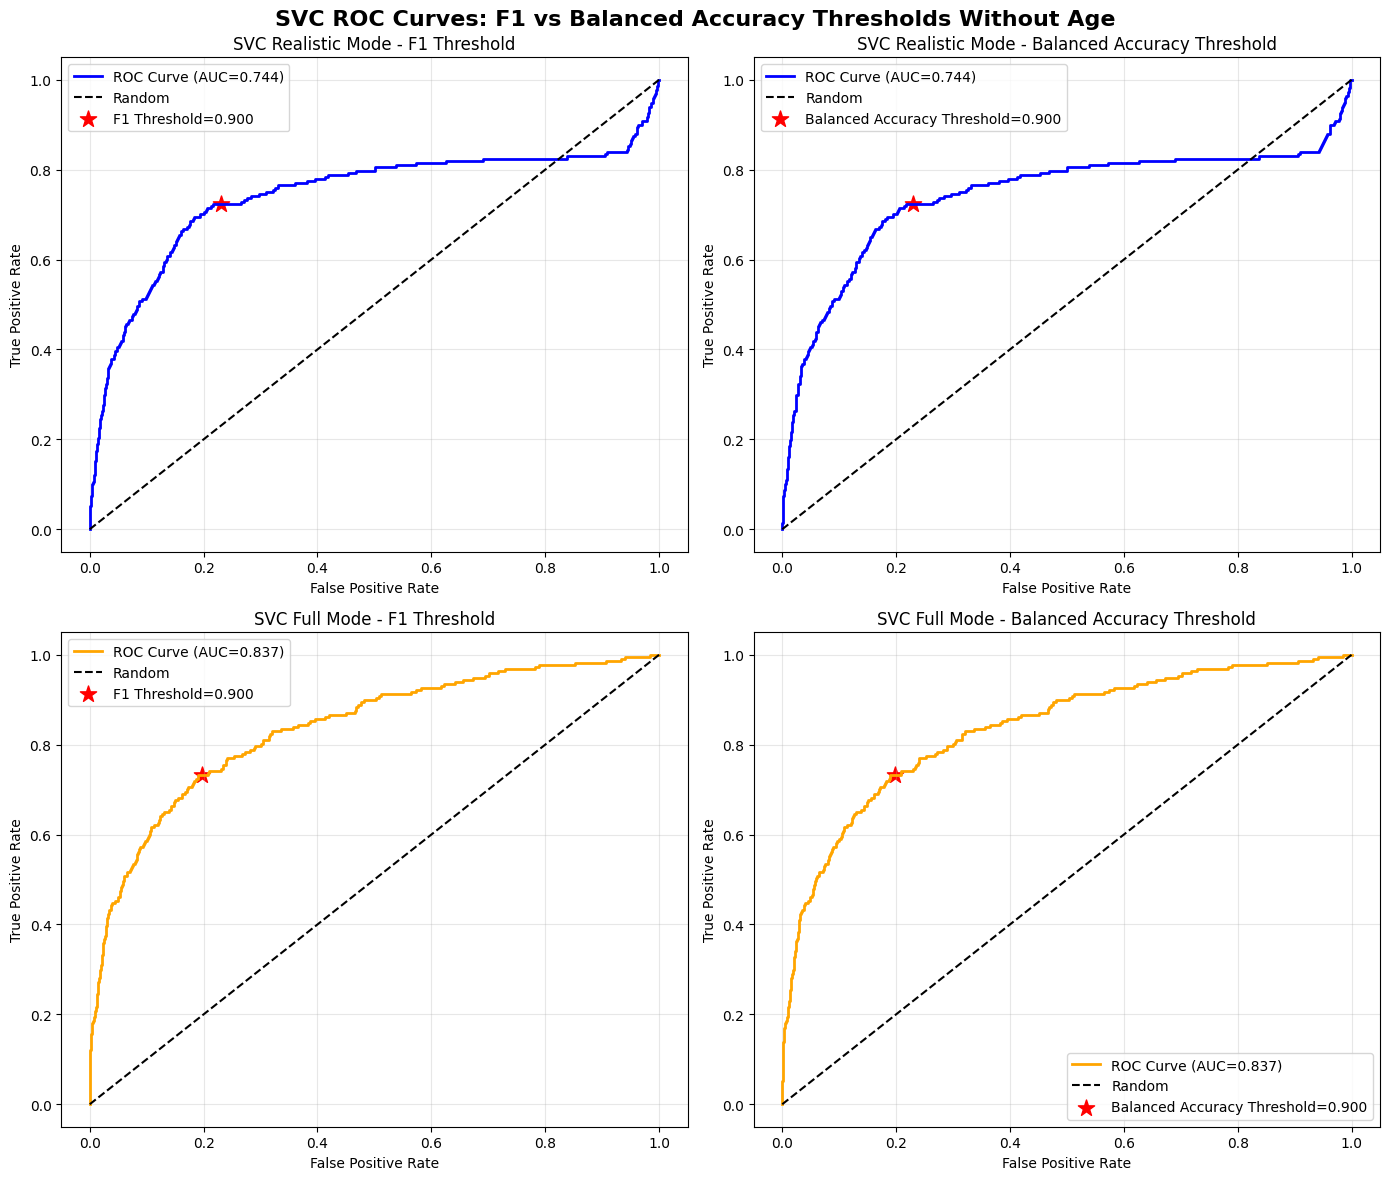

In [19]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Helper function to compute FPR/TPR for a threshold
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = (cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return fpr, tpr

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('SVC ROC Curves: F1 vs Balanced Accuracy Thresholds Without Age', fontsize=16, fontweight='bold')  

# -----------------------------
# SVC Realistic Mode
# -----------------------------
# Assuming y_test_pred_prop_realistic is calculated using svc_realistic_model
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
roc_auc_real = auc(fpr_real, tpr_real)

# F1 Threshold
fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, svc_realistic_model['thresholds']['F1'])
axes[0, 0].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 0].scatter(fpr_f1_real, tpr_f1_real, color='red', s=150, marker='*',
                   label=f'F1 Threshold={svc_realistic_model["thresholds"]["F1"]:.3f}')
axes[0, 0].set_title('SVC Realistic Mode - F1 Threshold') 
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(loc='best')

# Balanced Accuracy Threshold
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, svc_realistic_model['thresholds']['Balanced_Accuracy'])
axes[0, 1].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 1].scatter(fpr_bal_real, tpr_bal_real, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={svc_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}') 
axes[0, 1].set_title('SVC Realistic Mode - Balanced Accuracy Threshold') 
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(loc='best')

# -----------------------------
# SVC Full Mode
# -----------------------------
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)
roc_auc_full = auc(fpr_full, tpr_full)

# F1 Threshold
fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, svc_full_model['thresholds']['F1'])
axes[1, 0].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 0].scatter(fpr_f1_full, tpr_f1_full, color='red', s=150, marker='*',
                   label=f'F1 Threshold={svc_full_model["thresholds"]["F1"]:.3f}')
axes[1, 0].set_title('SVC Full Mode - F1 Threshold') 
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(loc='best')

# Balanced Accuracy Threshold
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, svc_full_model['thresholds']['Balanced_Accuracy'])
axes[1, 1].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 1].scatter(fpr_bal_full, tpr_bal_full, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={svc_full_model["thresholds"]["Balanced_Accuracy"]:.3f}') 
axes[1, 1].set_title('SVC Full Mode - Balanced Accuracy Threshold') 
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(loc='best')

plt.tight_layout()
plt.savefig("svc_roc_2x2_grid.png", dpi=300, bbox_inches='tight') 
plt.show()

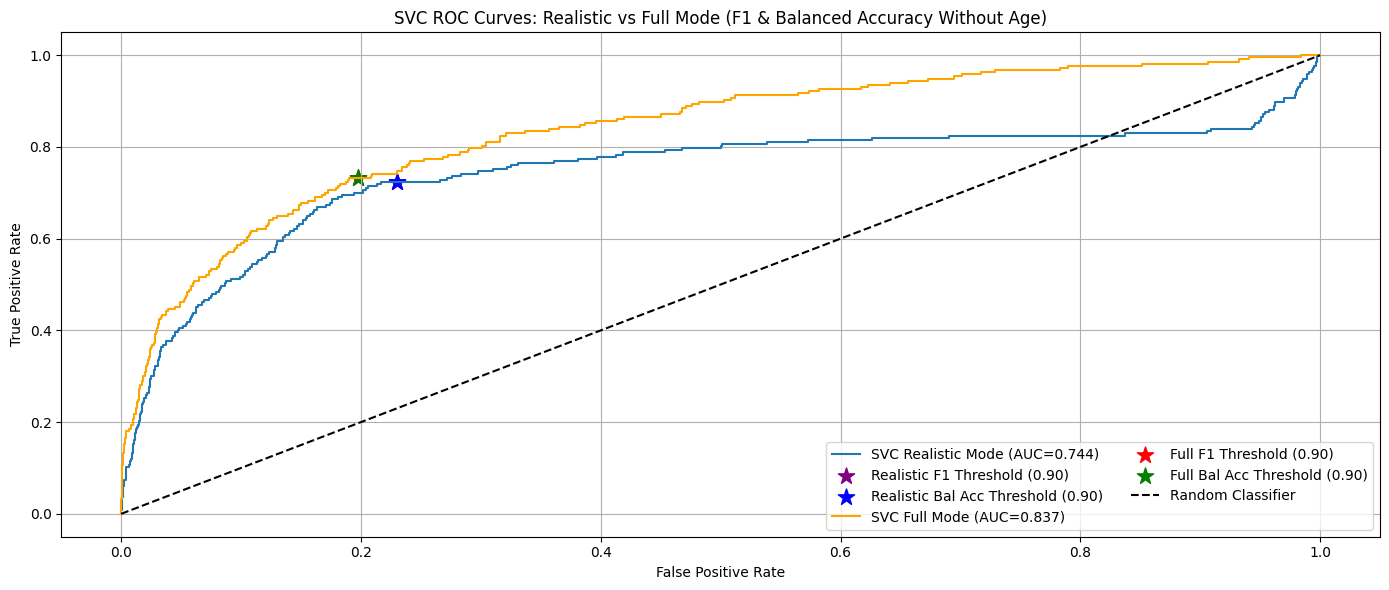

In [20]:
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)

roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_full = auc(fpr_full, tpr_full)

# Compute points for thresholds
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    # Using a try-except to safely access confusion matrix components
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = (cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return fpr, tpr

# use svc_realistic_model
fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, svc_realistic_model['thresholds']['F1'])
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, svc_realistic_model['thresholds']['Balanced_Accuracy'])

# use svc_full_model
fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, svc_full_model['thresholds']['F1'])
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, svc_full_model['thresholds']['Balanced_Accuracy'])

# Plot combined ROC
plt.figure(figsize=(14, 6))

#  SVC Realistic Mode 
plt.plot(fpr_real, tpr_real, label=f'SVC Realistic Mode (AUC={roc_auc_real:.3f})', linestyle='-') 
plt.scatter(fpr_f1_real, tpr_f1_real, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({svc_realistic_model["thresholds"]["F1"]:.2f})') 
plt.scatter(fpr_bal_real, tpr_bal_real, color='blue', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({svc_realistic_model["thresholds"]["Balanced_Accuracy"]:.2f})') 

#  SVC Full Mode 
plt.plot(fpr_full, tpr_full, label=f'SVC Full Mode (AUC={roc_auc_full:.3f})', color='orange', linestyle='-')
plt.scatter(fpr_f1_full, tpr_f1_full, color='red', marker='*', s=150, 
            label=f'Full F1 Threshold ({svc_full_model["thresholds"]["F1"]:.2f})') 
plt.scatter(fpr_bal_full, tpr_bal_full, color='green', marker='*', s=150, 
            label=f'Full Bal Acc Threshold ({svc_full_model["thresholds"]["Balanced_Accuracy"]:.2f})') 

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVC ROC Curves: Realistic vs Full Mode (F1 & Balanced Accuracy Without Age)") 
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("svc_roc_combined.png", dpi=300)
plt.show()

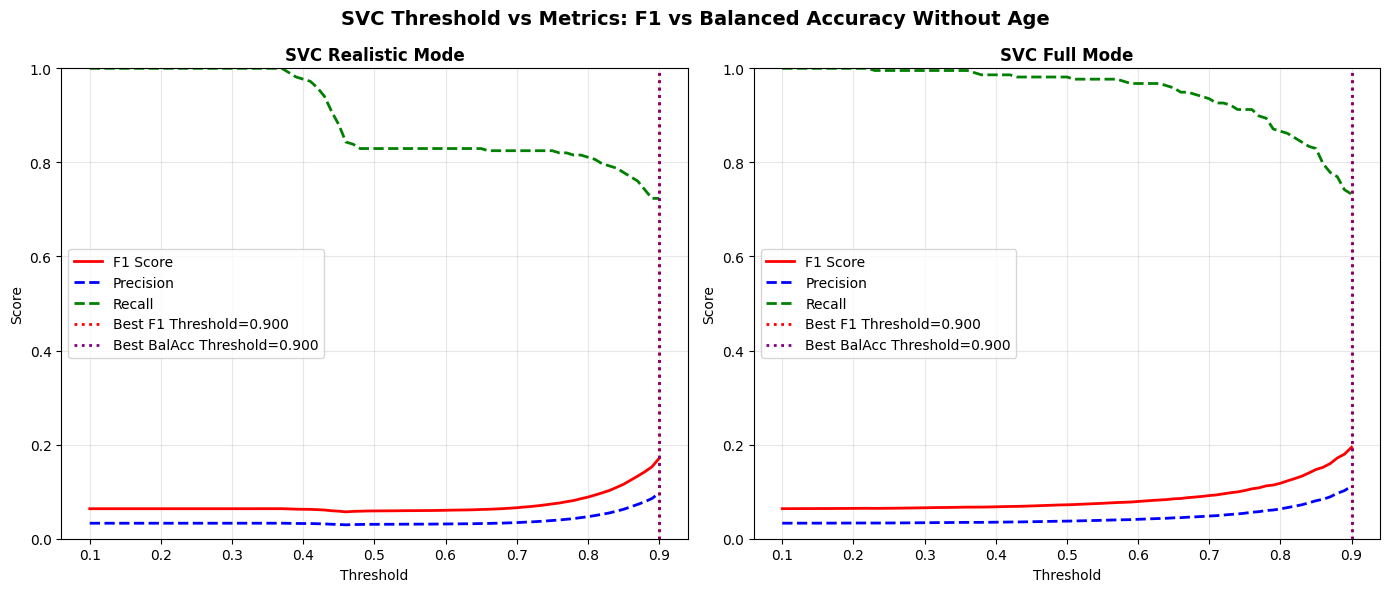

In [21]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Define threshold range
threshold_range = np.arange(0.1, 0.91, 0.01)

def compute_metrics(y_true, y_pred_prop, threshold_range):
    f1_scores, bal_acc_scores, precision_scores, recall_scores = [], [], [], []
    for t in threshold_range:
        y_pred_t = (y_pred_prop >= t).astype(int)
        # Set zero_division=0 to handle cases with no positive predictions
        f1_scores.append(f1_score(y_true, y_pred_t, zero_division=0))
        bal_acc_scores.append(balanced_accuracy_score(y_true, y_pred_t))
        precision_scores.append(precision_score(y_true, y_pred_t, zero_division=0))
        recall_scores.append(recall_score(y_true, y_pred_t, zero_division=0))
    return f1_scores, bal_acc_scores, precision_scores, recall_scores

#  Realistic Mode (Using SVC predictions) 
f1_scores_real, bal_acc_scores_real, precision_scores_real, recall_scores_real = compute_metrics(
    y_test, y_test_pred_prop_realistic, threshold_range
)

# Full Mode (Using SVC predictions)
f1_scores_full, bal_acc_scores_full, precision_scores_full, recall_scores_full = compute_metrics(
    y_test, y_test_pred_prop_full, threshold_range
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('SVC Threshold vs Metrics: F1 vs Balanced Accuracy Without Age', fontsize=14, fontweight='bold') 

# SVC Realistic Mode 
axes[0].plot(threshold_range, f1_scores_real, 'r-', linewidth=2, label='F1 Score')
axes[0].plot(threshold_range, precision_scores_real, 'b--', linewidth=2, label='Precision')
axes[0].plot(threshold_range, recall_scores_real, 'g--', linewidth=2, label='Recall')
axes[0].axvline(svc_realistic_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2, 
                 label=f'Best F1 Threshold={svc_realistic_model["thresholds"]["F1"]:.3f}')
axes[0].axvline(svc_realistic_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2, 
                 label=f'Best BalAcc Threshold={svc_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[0].set_title('SVC Realistic Mode', fontsize=12, fontweight='bold') # Updated Title
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_ylim([0, 1])

# SVC Full Mode
axes[1].plot(threshold_range, f1_scores_full, 'r-', linewidth=2, label='F1 Score')
axes[1].plot(threshold_range, precision_scores_full, 'b--', linewidth=2, label='Precision')
axes[1].plot(threshold_range, recall_scores_full, 'g--', linewidth=2, label='Recall')
axes[1].axvline(svc_full_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2,
                 label=f'Best F1 Threshold={svc_full_model["thresholds"]["F1"]:.3f}')
axes[1].axvline(svc_full_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2,
                 label=f'Best BalAcc Threshold={svc_full_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[1].set_title('SVC Full Mode', fontsize=12, fontweight='bold') # Updated Title
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig("svc_threshold_vs_metrics_pair_combined.png", dpi=300, bbox_inches='tight')
plt.show()